In [1]:
import cv2
import numpy as np
import os
import glob

# Innere Ecken (Anzahl Schnittpunkte, nicht Felder!)
CHECKERBOARD = (5, 8)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objpoints, imgpoints = [], []

square_size = 20.0  # mm
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size


# --- Pfade korrekt globs’en (hier rekursiv .jpg/.png) ---
base = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media"
patterns = [os.path.join(base, "**", "*.jpg"),
            os.path.join(base, "**", "*.jpeg"),
            os.path.join(base, "**", "*.png")]
images = []
for pat in patterns:
    images.extend(glob.glob(pat, recursive=True))
print(f"{len(images)} Bilddateien gefunden.")

valid_size = None

for fname in images[0:10]:
    # Direkt in Grau laden
    gray = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        print(f"Überspringe (nicht lesbar): {fname}")
        continue

    # Ecken suchen
    ret, corners = cv2.findChessboardCorners(
        gray, CHECKERBOARD,
        flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_NORMALIZE_IMAGE
    )

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        valid_size = gray.shape[::-1]  # (width, height)
    print(ret, fname)
# cv2.destroyAllWindows()

if not imgpoints:
    raise RuntimeError("Keine gültigen Schachbrett-Ecken gefunden. "
                       "Prüfe CHECKERBOARD-Größe, Bildqualität und Ausrichtung.")

# Kalibrieren
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, valid_size, None, None
)

print("Camera matrix:\n", mtx)
print("dist:\n", dist)
print("Translationsvektor: ", tvecs[0],"\n", "Rotationsvektor: ", rvecs[0])


97 Bilddateien gefunden.
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame0.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame1.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame10.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame11.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame12.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame13.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame14.jpg
False G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame15.jpg
False G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame16.jpg
True G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media\frame17.jpg
Camera matrix:
 [[1.07040479e+03 0.00000000e+00 9.75493795e+02]
 [0.00000000e+00 1.07004841e+03 5.25928744e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist:
 [[-0.38

0.05056047439575195


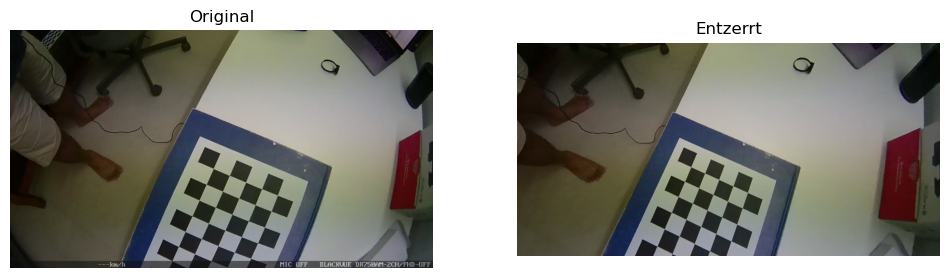

In [2]:
import cv2, glob, os
import matplotlib.pyplot as plt
import time

folder = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Media"  # Pfad anpassen
# Erstes JPG oder PNG im Ordner nehmen
files = glob.glob(os.path.join(folder, "*.jpg")) + glob.glob(os.path.join(folder, "*.png"))
assert files, "Kein passendes Bild gefunden."
img = cv2.imread(files[80])
h, w = img.shape[:2]

# Optimale Kameramatrix berechnen und entzerren
newK, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

start = time.time()
undist = cv2.undistort(img, mtx, dist, None, newK)
end = time.time()
print(end-start)
# Optional croppen
x, y, cw, ch = roi
if cw > 0 and ch > 0:
    undist = undist[y:y+ch, x:x+cw]

# In RGB umwandeln (OpenCV liest BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist_rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

# Plotten in Jupyter
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(undist_rgb)
axes[1].set_title("Entzerrt")
axes[1].axis("off")

plt.show()


In [3]:
import cv2
import numpy as np
# --- Annahme: mtx, dist aus der Kalibrierung vorhanden ---
# --- CHECKERBOARD Maße: innere Ecken ---
CHECKERBOARD = (5, 8)
square_size = 1  # mm oder deine Einheit

# 3D-Punkte des Bretts
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= square_size

def pose_from_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, None)
    if not ret:
        return None
    corners = cv2.cornerSubPix(
        img, corners, (11,11), (-1,-1),
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    )
    ok, rvec, tvec = cv2.solvePnP(objp, corners, mtx, dist)
    return (rvec, tvec) if ok else None


# Zwei Bilder aus verschiedenen Positionen
rvec1, tvec1 = pose_from_image(files[46])
rvec2, tvec2 = pose_from_image(files[76])

#über files loopen und vektoren in liste speichern
# Liste der (file, rvec, tvec)
vektoren = [
    (f, res[0], res[1])
    for f in files
    if (res := pose_from_image(f)) is not None
]

print(len(vektoren), "gültige Posen gefunden")

# Relative Translation: Kamera2 relativ zu Kamera1
R1, _ = cv2.Rodrigues(rvec1)
R2, _ = cv2.Rodrigues(rvec2)
# Vom Brett-KS ins Kamera-KS
cam1_in_brett = -R1.T @ tvec1
cam2_in_brett = -R2.T @ tvec2

relative_position = cam2_in_brett - cam1_in_brett
print("Translationsvektor Bild 2:", tvec2, " Translationsvektor Bild1: ", tvec1)
print("Relative position:", relative_position)

74 gültige Posen gefunden
Translationsvektor Bild 2: [[-1.5959074 ]
 [ 3.56790813]
 [19.89732051]]  Translationsvektor Bild1:  [[-9.03182776]
 [ 1.02695335]
 [30.22112227]]
Relative position: [[-21.37290821]
 [  3.54148372]
 [ 12.77849791]]


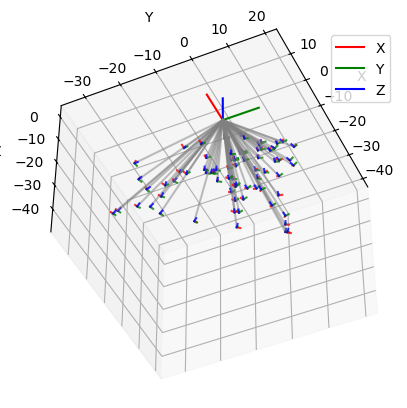

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Weltachsen (10 Einheiten lang)
ax.plot([0, 10], [0, 0], [0, 0], color='r', label='X')
ax.plot([0, 0], [0, 10], [0, 0], color='g', label='Y')
ax.plot([0, 0], [0, 0], [0, 10], color='b', label='Z')

# Sammle alle Vektoren
all_x, all_y, all_z = [0], [0], [0]




# plotte alle Vektoren aus der Liste
for _, rvec, tvec in vektoren:
    s = 1.0
    R, _ = cv2.Rodrigues(np.asarray(rvec, dtype=float).ravel())

    # Kamerazentrum (Weltkoordinaten) und Kamera->Welt-Rotation
    C = (-R.T @ np.asarray(tvec, dtype=float).reshape(3,1)).ravel()
    Rcw = R.T

    # Achsenrichtungen (jeweils Länge 3)
    ex, ey, ez = Rcw[:,0]*s, Rcw[:,1]*s, Rcw[:,2]*s

    # Position als Linie vom Ursprung (optional)
    ax.plot([0, C[0]], [0, C[1]], [0, C[2]], color='gray', alpha=0.5)

    # Lokales Kamera-Frame an C zeichnen
    ax.plot([C[0], C[0]+ex[0]], [C[1], C[1]+ex[1]], [C[2], C[2]+ex[2]], color='r', alpha=0.8)
    ax.plot([C[0], C[0]+ey[0]], [C[1], C[1]+ey[1]], [C[2], C[2]+ey[2]], color='g', alpha=0.8)
    ax.plot([C[0], C[0]+ez[0]], [C[1], C[1]+ez[1]], [C[2], C[2]+ez[2]], color='b', alpha=0.8)

    # Für Limits alle Endpunkte sammeln (optional)
    all_x += [C[0], C[0]+ex[0], C[0]+ey[0], C[0]+ez[0]]
    all_y += [C[1], C[1]+ex[1], C[1]+ey[1], C[1]+ez[1]]
    all_z += [C[2], C[2]+ex[2], C[2]+ey[2], C[2]+ez[2]]

# Achsenlimits basierend auf allen Punkten
pad = 0.1 * max(np.ptp(all_x), np.ptp(all_y), np.ptp(all_z))
ax.set_xlim(min(all_x)-pad, max(all_x)+pad)
ax.set_ylim(min(all_y)-pad, max(all_y)+pad)
ax.set_zlim(min(all_z)-pad, max(all_z)+pad)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot drehen: Elevation = Höhe, Azimuth = horizontaler Winkel
ax.view_init(elev=-45, azim=25)  # z. B. 20° hoch, 45° seitlich

ax.legend()
plt.show()


In [39]:
###Umrechnen der pixel brennweiten in mm
#verhältnis
#pixelgröße bestimmen:
px, py =  len(cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)[0]), len(cv2.imread(images[0], cv2.IMREAD_GRAYSCALE))
print(px, py)
FOVh = 2 * np.arctan(px / (mtx[0][0] * 2))
FOVv = 2 * np.arctan(py / (mtx[1][1] * 2))
print(f"Horizontaler Winkel: {np.degrees(FOVh):.2f}°")
print(f"Vertikaler Winkel: {np.degrees(FOVv):.2f}°")

1920 1080
Horizontaler Winkel: 81.48°
Vertikaler Winkel: 51.61°
